Torch implementation of AA - When done should be moved to a .py file to allow easy implementation, or alternatively allow saving of model parameters

In [1]:
import torch
import numpy as np
import pandas as pd

from helpers.data import X
from helpers.callbacks import earlyStop
from helpers.losses import frobeniusLoss
from helpers.initializers import FurthestSum, MeanPeaks

import matplotlib.pyplot as plt



C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [9]:
class torchAA(torch.nn.Module):
    def __init__(self, X, rank):
        super(torchAA, self).__init__()
        
        #Shape of Matrix for reproduction
        n_row, n_col = X.shape
        self.X = torch.tensor(X)
        
        #softmax layer
        self.softmax = torch.nn.Softmax(dim = 1)
        
        # Initialization of Tensors/Matrices S and C

        # cols = FurthestSum(X, rank, 1)
        cols = MeanPeaks(X, rank)
        self.C = X.T[cols]
        self.C = torch.tensor(self.C.T, requires_grad=True)
        self.C = torch.nn.Parameter(self.C)
        
        # self.C = torch.nn.Parameter(torch.rand(n_col, rank, requires_grad=True))
        self.S = torch.nn.Parameter(torch.rand(rank, n_row, requires_grad=True))
        
    def forward(self):
        #Implementation of AA - F(C, S) = ||X - XCS||^2
        
        #first matrix Multiplication with softmax
        self.XC = torch.matmul(self.X.T.double(),
                                self.softmax(
                                self.C.double()))
        
        self.XCS = torch.matmul(self.XC.double(),
                                self.softmax(
                                self.S.double()))
        # print(self.XCS.shape)
        
        x = self.X - self.XCS.T
        
        return x

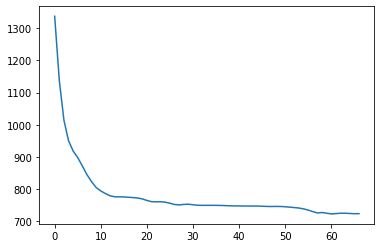

In [10]:
torch.manual_seed(0)

aa = torchAA(X, 3)

#optimizer for modifying learning rate, ADAM chosen because of https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/
optimizer = torch.optim.Adam(aa.parameters(), lr=0.3)

#early stopping
es = earlyStop(patience=5, offset=-0.1)

running_loss = []

while (not es.trigger()):
    #zero optimizer gradient
    optimizer.zero_grad()

    #forward
    output = aa()
    
    #backward
    loss = frobeniusLoss()
    loss = loss.forward(output)
    loss.backward()
    
    #Update A and B
    optimizer.step()
    
    #append loss for graphing
    running_loss.append(loss.item())
    
    #count with early stopping
    es.count(loss.item())
    
    #print loss
    print(f"epoch: {len(running_loss)}, Loss: {loss.item()}", end='\r')
    
plt.plot(running_loss)
plt.show()

In [11]:
# print(list(aa.parameters())[1].shape)

C, S = list(aa.parameters())

C = aa.softmax(C)
S = aa.softmax(S)

C = C.detach().numpy()
S = S.detach().numpy()

XC = np.dot(X.T, C)
rec = np.dot(XC, S)

rec_frame = pd.DataFrame(rec)
rec_frame.columns = rec_frame.columns.astype(str)

rec_frame.to_parquet("recons_x.parquet",
                     engine = 'fastparquet')